In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import constants as const
import db_operations as dbop
import data_prepare as dp
import ml_model
import customized_obj as cus_obj

import xgboost.sklearn as xgb
import lightgbm.sklearn as lgbm
import sklearn.preprocessing as preproc
import sklearn.metrics as metrics

import datetime
import time

2018-01-01 2011-02-27 2009-02-07
start: 2009-02-07


min_date 2009-02-09


count stck 58
(120669, 165)
(120669, 165)


(2404, 395) 2404


(120669, 560)


df_all: (100440, 560)


y<-0.5: 0
-0.50<=y<-0.40: 1
-0.40<=y<-0.30: 0
-0.30<=y<-0.20: 2
-0.20<=y<-0.10: 49
-0.10<=y<0.00: 6653
0.00<=y<0.10: 55292
0.10<=y<0.20: 23805
0.20<=y<0.30: 7943
0.30<=y<0.40: 2857
0.40<=y<0.50: 1189
y>0.5 1483
mean: 0.10480536302230424 median: 0.0714285714285714 std: 0.208926423468556


过滤一字涨停项或停牌（最高价=最低价）： 5412
y<-0.5: 0
-0.50<=y<-0.40: 0
-0.40<=y<-0.30: 0
-0.30<=y<-0.20: 0
-0.20<=y<-0.10: 45
-0.10<=y<0.00: 6585
0.00<=y<0.10: 56914
0.10<=y<0.20: 23336
0.20<=y<0.30: 7655
0.30<=y<0.40: 2634
0.40<=y<0.50: 1056
y>0.5 1049
mean: 0.09575991408283223 median: 0.06787124860496829 std: 0.10911115377146031


y<-0.5: 259
-0.50<=y<-0.40: 449
-0.40<=y<-0.30: 1373
-0.30<=y<-0.20: 4781
-0.20<=y<-0.10: 22615
-0.10<=y<0.00: 64516
0.00<=y<0.10: 5283
0.10<=y<0.20: 0
0.20<=y<0.30: 0
0.30<=y<0.40: 0
0.40<=y<0.50: 0
y>0.5 0
mean: -0.07966692289307906 median: -0.05891394813420481 std: 0.07858335509769401


过滤一字涨停项或停牌（最高价=最低价）： 5412
y<-0.5: 187
-0.50<=y<-0.40: 373
-0.40<=y<-0.30: 1281
-0.30<=y<-0.20: 4616
-0.20<=y<-0.10: 22154
-0.10<=y<0.00: 63778
0.00<=y<0.10: 6887
0.10<=y<0.20: 0
0.20<=y<0.30: 0
0.30<=y<0.40: 0
0.40<=y<0.50: 0
y>0.5 0
mean: -0.07709014416755186 median: -0.056872037914691864 std: 0.07580003674146726


(100440, 545) (100440, 3) Index(['y_l_rise', 'y_l_decline', 'y_l'], dtype='object')


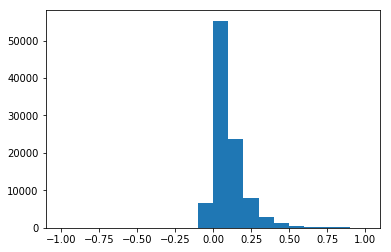

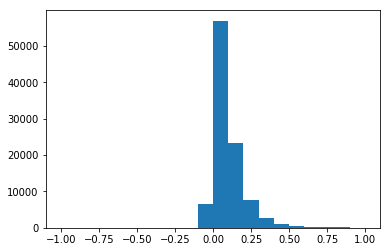

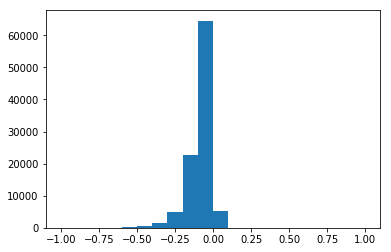

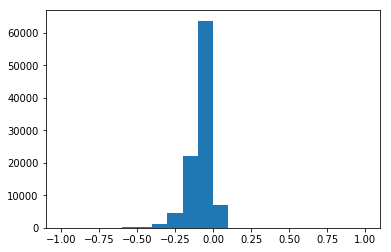

In [2]:
targets = [{"period": 20, "fun": "max", "col": "high"},
           {"period": 20, "fun": "min", "col": "low"},
           # {"period": 5, "fun": "max", "col": "high"},
           # {"period": 5, "fun": "min", "col": "low"},
           # {"period": 20, "fun": "mean", "col": ""}
           ]

time_delta = datetime.timedelta(days=1)
test_start = "2018-01-01"
train_length = 2500
max_feature_length = 750

train_bound = datetime.datetime.strptime(test_start, const.DATE_FORMAT) - train_length * time_delta
train_bound = datetime.datetime.strftime(train_bound, const.DATE_FORMAT)

lower_bound = datetime.datetime.strptime(train_bound, const.DATE_FORMAT) - max_feature_length * time_delta
lower_bound = datetime.datetime.strftime(lower_bound, const.DATE_FORMAT)
print(test_start,train_bound,lower_bound)

df_all, cols_future = ml_model.gen_data(targets=targets,
                                        lower_bound=lower_bound,
                                        start=train_bound,
                                        stock_pool=None)

print("df_all:", df_all.shape)
trading_date_idxes = df_all.index.unique().sort_values(ascending=True)

X = ml_model.gen_X(df_all, cols_future)

paras = [("y_l_rise", {"pred_period": 20, "is_high": True, "is_clf": False,"threshold":0.2}, df_all),
         ("y_l_decline", {"pred_period": 20, "is_high": False, "is_clf": False, "threshold":0.2}, df_all),
         # ("y_s_rise", {"pred_period": 5, "is_high": True, "is_clf": False,"threshold":0.1}, df_all),
         # ("y_s_decline", {"pred_period": 5, "is_high": False, "is_clf": False,"threshold":0.1}, df_all),
         ]

# paras = [("y_l", {"pred_period": 20, "is_high": True, "is_clf": False,
#                        "threshold":0.1}, df_all)]
Y = pd.concat([ml_model.gen_y(v2, **v1) for k, v1, v2 in paras], axis=1)
Y.columns = [k for k, _, _ in paras]
Y.index = X.index
Y["y_l"] = Y.apply(
    lambda r:r["y_l_rise"] if r["y_l_rise"]> -r["y_l_decline"] else r["y_l_decline"],
    axis=1)
print(X.shape, Y.shape, Y.columns)


(100440, 545)
Index(['code', 'f19max_f2mv_high', 'f1mv_close', 'f1mv_high', 'f1mv_low',
       'f1mv_open', 'f1mv_qfq_close', 'f1mv_qfq_high', 'f1mv_qfq_low',
       'f1mv_qfq_open', 'f20min_f1mv_low', 'qfq_close', 'qfq_high', 'qfq_low',
       'qfq_open'],
      dtype='object')


(array([    0.,     0.,     0.,    32.,   155.,   373.,  1273.,  4497.,
        19952., 16913., 22261., 21592.,  7498.,  2623.,  1056.,   491.,
          241.,   141.,    88.,    44.]),
 array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,
         0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 20 Patch objects>)

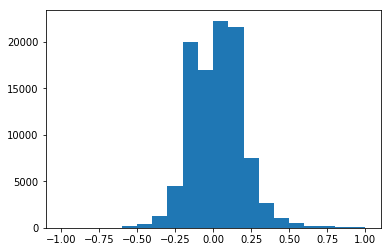

In [3]:
print(X.shape)
print(df_all.columns.difference(X.columns))
plt.hist(Y["y_l"].dropna(),bins=np.arange(-10,11)*0.1)

In [4]:
# Y is contiguous.
for col in Y.columns:
    print(col, Y[col].mean(),Y[col].median(),Y[col].std())

y_l_rise 0.09575991408283223 0.06787124860496829 0.10911115377146031
y_l_decline -0.07709014416755186 -0.056872037914691864 0.07580003674146726
y_l 0.02370337386638679 0.0381458232737808 0.1728694636282881


In [5]:
train_date_idx = trading_date_idxes[trading_date_idxes<"2017-01-01"][:-21]
print(train_date_idx[0],train_date_idx[-1])
test_date_idx = trading_date_idxes[(trading_date_idxes>="2017-01-01")][:-21]
print(test_date_idx[0],test_date_idx[-1])

ycol = "y_l"
X_train = X.loc[train_date_idx]
Y_train = Y.loc[train_date_idx]
print(X_train.shape, Y_train[ycol].shape)
X_test = X.loc[test_date_idx]
Y_test = Y.loc[test_date_idx]
print(X_test.shape, Y_test.shape)


2011-02-28 2016-12-01
2017-01-03 2018-11-20


(72349, 545) (72349,)


(25742, 545) (25742, 3)


In [6]:
models={}

In [25]:

# models = {"model_l_high":
#               xgb.XGBClassifier(n_estimators=150, 
#                                   scale_pos_weight=1,
#                                 max_depth=5,
#                                  random_state=0, 
#                                   )
#           }

models["model_l_high"]=lgbm.LGBMClassifier(n_estimators=30, 
                                  scale_pos_weight=1,
                                 num_leaves=64, 
                                max_depth=8,
                                 random_state=0, 
                                min_child_samples=20,
                                  )
          

y_train = ml_model.label(Y_train[ycol],threshold=0.15,is_high=True)
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

t1 = time.time()
models["model_l_high"].fit(X_train, y_train)
t2 = time.time()
print(t2-t1)
Y_test_pred ={ycol: models["model_l_high"].predict_proba(X_test)[:,1]}


78.3270001411438


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=8, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=30,
        n_jobs=-1, num_leaves=64, objective=None, random_state=0,
        reg_alpha=0.0, reg_lambda=0.0, scale_pos_weight=1, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


781 (0.0017869685491264144, 0.0, 0.0196784538425522, 0.40542133176193307, -0.0802784222737819)
1710 (0.05386594665278017, 0.037338541666666614, 0.05928159829582074, 0.46347826086956534, -0.07043407043407057)
4228 (0.07411173725992358, 0.056048587659362714, 0.07320788490381518, 0.8043636363636364, -0.12865267699548932)
4905 (0.08498451283253235, 0.06495335328287277, 0.0844883485564575, 0.8832684824902723, -0.09234608985024961)
4190 (0.08855994882126494, 0.06896776502608803, 0.08806563656192254, 0.8724528301886791, -0.19402173913043474)
3305 (0.09120448303750107, 0.07098121085595, 0.08792687472357531, 0.6553672316384183, -0.11646136618141101)
2281 (0.09833946597301156, 0.0726086956521741, 0.09894210821771089, 0.7660103626587744, -0.10780487804878058)
1529 (0.09985295195556354, 0.07685799654449066, 0.09982384758165438, 0.6616257088846884, -0.0632380952380952)
932 (0.09520443086642888, 0.07073569055827711, 0.0960636104784121, 0.597989949748744, -0.0708556149732621)
549 (0.0997234051263998,

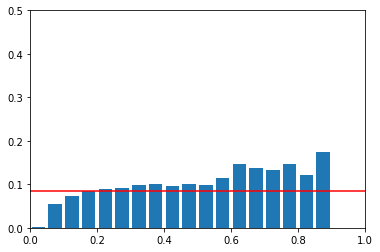

In [26]:
print(models["model_l_high"])

interval = 0.05
n = int(1/interval)
x0 = np.arange(n+1)*interval
y0 = np.ones(x0.shape)* Y_test[ycol].mean()

y1 = []
cnt1 = []
for i in range(n):
    p0 = i*interval
    p1 = (i+1)*interval
    cond=(p0 < Y_test_pred[ycol]) & (Y_test_pred[ycol] <=p1)
    cnt1.append(sum(cond))
    y1.append((Y_test[ycol][cond].mean(), Y_test[ycol][cond].median(),Y_test[ycol][cond].std(),Y_test[ycol][cond].max(),Y_test[ycol][cond].min()))
for c,p in zip(cnt1,y1):
    print(c,p)

plt.bar(np.arange(len(y1))*interval+interval/2,[mean for mean,_, _,_,_ in y1],width=interval*0.8)
plt.plot(x0,y0,color='r')
# plt.plot(x,y1,color='r')
plt.xlim(0,1)
plt.ylim(0,0.5)
plt.show()


In [12]:
cond = Y_test_pred[ycol]>0.7
print(Y_test[ycol][cond].mean())
print(sum(cond),Y_test[ycol][cond].mean(), Y_test[ycol][cond].median(),Y_test[ycol][cond].std(),Y_test[ycol][cond].max(),Y_test[ycol][cond].min())

df_combined = df_all.loc[test_date_idx][["code","open0","open","f1mv_open"]]
df_combined["rise"] = Y_test[ycol].copy()
df_combined["pred"] = Y_test_pred[ycol].copy()
for code, df in df_combined[cond].groupby("code"):
    print("\n",df)

0.19150086981583767
6 0.19150086981583767 0.1749581416624233 0.14266972179444173 0.3796449704142011 0.04947916666666674

                  code  open0       open   f1mv_open     rise     pred
2017-06-14  000002.SZ   21.9  2907.9258  2822.94532  0.25588  0.73034

                  code  open0     open  f1mv_open      rise      pred
2018-02-06  002446.SZ    7.2  35.6184   34.67847  0.312411  0.744096

                  code  open0      open  f1mv_open      rise      pred
2017-06-02  600401.SH   1.39  26.22652   26.22652  0.057554  0.718362

                  code  open0     open  f1mv_open      rise      pred
2017-05-24  600536.SH   19.3  101.518    100.992  0.049479  0.705735

                  code  open0     open  f1mv_open      rise      pred
2017-05-09  603799.SH   44.0  44.2640    43.8616  0.094037  0.731686
2017-05-23  603799.SH   42.7  42.9562    42.5035  0.379645  0.730326


In [12]:
models["model_l_high_reg"] = lgbm.LGBMRegressor(
    n_estimators=30, num_leaves=32,
    max_depth=-1,
    random_state=0,
    min_child_samples=20,
    min_split_gain=0,
    objective = cus_obj.sigmoid_lt_obj_generator(20,-0.15),reg_lambda=1e-5
)

sample_weight = np.abs(Y_train[ycol])
sample_weight = sample_weight/np.mean(sample_weight)

t1 = time.time()
# models["model_l_high_reg"].fit(X_train, Y_train[ycol],sample_weight=sample_weight)
models["model_l_high_reg"].fit(X_train, Y_train[ycol])
t2 = time.time()
print(t2-t1)


13.41100025177002


In [20]:

Y_test_pred_reg ={ycol: models["model_l_high_reg"].predict(X_test)}
print(models["model_l_high_reg"].score(X_test,Y_test[ycol]))


53.545000076293945


In [52]:
stacker = lgbm.LGBMClassifier(
    n_estimators=30, num_leaves=64,
    scale_pos_weight=1,
    max_depth=16,
    random_state=0,
    min_child_samples=20,
    min_split_gain=0.5,
)


C:\Users\dell-pc\Anaconda3.6\lib\site-packages\lightgbm\basic.py:450: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


(16568,)


1292 (0.0564942141165419, 0.025359140081381515, 0.07957201925528411, 0.49437299035369775, -0.014883061658398145)
3497 (0.09504616791963497, 0.0726246105919004, 0.09024243654398367, 0.741324921135647, -0.09234608985024961)
3106 (0.09408139306308058, 0.07244620752160258, 0.08945663814447036, 0.7047560222359481, -0.09142053445850917)
2325 (0.08616052449963223, 0.06269592476489039, 0.08869867514290783, 0.6974169741697416, -0.058252427184466105)
2245 (0.08677626347111263, 0.06336206896551722, 0.08857897064228236, 0.7660103626587744, -0.04995196926032652)
2344 (0.09731225216002441, 0.07690981432360733, 0.0895432363424026, 0.597989949748744, -0.0632380952380952)
1277 (0.09841958194967271, 0.07598944591029033, 0.0909535346164598, 0.5143859649122804, -0.06426056338028152)
450 (0.0868233603157824, 0.06349306651094266, 0.08943101591540087, 0.476747587013747, -0.10578478964401283)
20 (0.10391456215211621, 0.07400945030202, 0.09942987060625445, 0.31241084165477906, -0.0139113555483662)
12 (0.060183

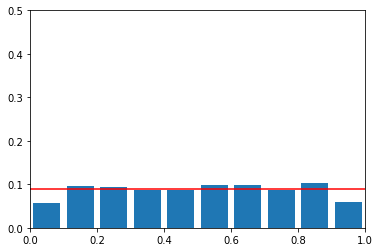

In [174]:

import sklearn as sk
enc = sk.preprocessing.OneHotEncoder()
pred_leaves_train = models["model_l_high_reg"].predict(X_train, pred_leaf=True)
pred_reg_train = models["model_l_high_reg"].predict(X_train).reshape(-1, 1)
pred_leaves_train = enc.fit_transform(pred_leaves_train)
print(pred_leaves_train.shape,X_train.shape, type(pred_leaves_train),
      type(X_train))
import scipy.sparse
features_train = scipy.sparse.hstack([X_train,pred_leaves_train])
print(features_train.shape, type(features_train))
features_train = scipy.sparse.hstack([features_train, pred_reg_train])
print(features_train.shape, type(features_train))


C:\Users\dell-pc\Anaconda3.6\lib\site-packages\lightgbm\basic.py:450: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


(16568,)


1292 (0.0564942141165419, 0.025359140081381515, 0.07957201925528411, 0.49437299035369775, -0.014883061658398145)
3497 (0.09504616791963497, 0.0726246105919004, 0.09024243654398367, 0.741324921135647, -0.09234608985024961)
3106 (0.09408139306308058, 0.07244620752160258, 0.08945663814447036, 0.7047560222359481, -0.09142053445850917)
2325 (0.08616052449963223, 0.06269592476489039, 0.08869867514290783, 0.6974169741697416, -0.058252427184466105)
2245 (0.08677626347111263, 0.06336206896551722, 0.08857897064228236, 0.7660103626587744, -0.04995196926032652)
2344 (0.09731225216002441, 0.07690981432360733, 0.0895432363424026, 0.597989949748744, -0.0632380952380952)
1277 (0.09841958194967271, 0.07598944591029033, 0.0909535346164598, 0.5143859649122804, -0.06426056338028152)
450 (0.0868233603157824, 0.06349306651094266, 0.08943101591540087, 0.476747587013747, -0.10578478964401283)
20 (0.10391456215211621, 0.07400945030202, 0.09942987060625445, 0.31241084165477906, -0.0139113555483662)
12 (0.060183

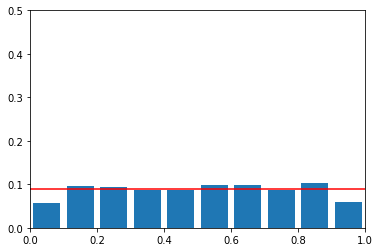

In [180]:
t1 = time.time()
stacker.fit(features_train,ml_model.label(Y_train[ycol],threshold=0.15))
# stacker.fit(features_train,Y_train[ycol])
t2 = time.time()
print(t2-t1)

C:\Users\dell-pc\Anaconda3.6\lib\site-packages\lightgbm\basic.py:450: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


(16568,)


1292 (0.0564942141165419, 0.025359140081381515, 0.07957201925528411, 0.49437299035369775, -0.014883061658398145)
3497 (0.09504616791963497, 0.0726246105919004, 0.09024243654398367, 0.741324921135647, -0.09234608985024961)
3106 (0.09408139306308058, 0.07244620752160258, 0.08945663814447036, 0.7047560222359481, -0.09142053445850917)
2325 (0.08616052449963223, 0.06269592476489039, 0.08869867514290783, 0.6974169741697416, -0.058252427184466105)
2245 (0.08677626347111263, 0.06336206896551722, 0.08857897064228236, 0.7660103626587744, -0.04995196926032652)
2344 (0.09731225216002441, 0.07690981432360733, 0.0895432363424026, 0.597989949748744, -0.0632380952380952)
1277 (0.09841958194967271, 0.07598944591029033, 0.0909535346164598, 0.5143859649122804, -0.06426056338028152)
450 (0.0868233603157824, 0.06349306651094266, 0.08943101591540087, 0.476747587013747, -0.10578478964401283)
20 (0.10391456215211621, 0.07400945030202, 0.09942987060625445, 0.31241084165477906, -0.0139113555483662)
12 (0.060183

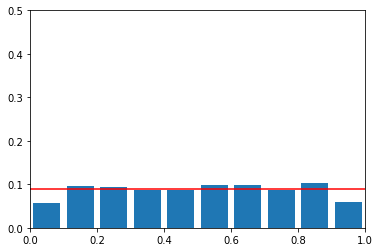

In [176]:
pred_leaves_test = models["model_l_high_reg"].predict(X_test, pred_leaf=True)
pred_reg_test = models["model_l_high_reg"].predict(X_test).reshape(-1, 1)
pred_leaves_test = enc.transform(pred_leaves_test)
print(pred_leaves_test.shape,X_test.shape, type(pred_leaves_test),
      type(X_test))
features_test = scipy.sparse.hstack([X_test, pred_leaves_test])
print(features_test.shape, type(features_test))
features_test = scipy.sparse.hstack([features_test, pred_reg_test])
print(features_test.shape, type(features_test))


C:\Users\dell-pc\Anaconda3.6\lib\site-packages\lightgbm\basic.py:450: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


(16568,)


1292 (0.0564942141165419, 0.025359140081381515, 0.07957201925528411, 0.49437299035369775, -0.014883061658398145)
3497 (0.09504616791963497, 0.0726246105919004, 0.09024243654398367, 0.741324921135647, -0.09234608985024961)
3106 (0.09408139306308058, 0.07244620752160258, 0.08945663814447036, 0.7047560222359481, -0.09142053445850917)
2325 (0.08616052449963223, 0.06269592476489039, 0.08869867514290783, 0.6974169741697416, -0.058252427184466105)
2245 (0.08677626347111263, 0.06336206896551722, 0.08857897064228236, 0.7660103626587744, -0.04995196926032652)
2344 (0.09731225216002441, 0.07690981432360733, 0.0895432363424026, 0.597989949748744, -0.0632380952380952)
1277 (0.09841958194967271, 0.07598944591029033, 0.0909535346164598, 0.5143859649122804, -0.06426056338028152)
450 (0.0868233603157824, 0.06349306651094266, 0.08943101591540087, 0.476747587013747, -0.10578478964401283)
20 (0.10391456215211621, 0.07400945030202, 0.09942987060625445, 0.31241084165477906, -0.0139113555483662)
12 (0.060183

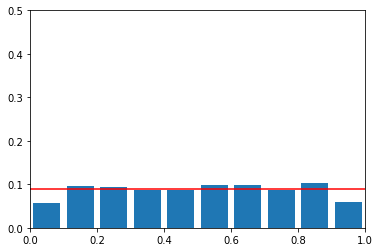

In [182]:
y_stacker_test = stacker.predict_proba(features_test)[:,1]
# y_stacker_test = stacker.predict(features_test)

print(y_stacker_test.shape)
y1 = []
cnt1 = []
for i in range(10):
    p0 = i*0.1
    p1 = (i+1)*0.1
    cond=(p0 < y_stacker_test) & (y_stacker_test <=p1)
    cnt1.append(sum(cond))
    y1.append((Y_test[ycol][cond].mean(), Y_test[ycol][cond].median(),Y_test[ycol][cond].std(),Y_test[ycol][cond].max(),Y_test[ycol][cond].min()))
for c,p in zip(cnt1,y1):
    print(c,p)

plt.bar(np.arange(len(y1))*0.1+0.05,[mean for mean,_, _,_,_ in y1],width=0.08)
plt.plot(x0,y0,color='r')
# plt.plot(x,y1,color='r')
plt.xlim(0,1)
plt.ylim(0,0.5)
plt.show()

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0, n_estimators=30,
       n_jobs=-1, num_leaves=32,
       objective=<function sigmoid_lt_obj_generator.<locals>.sigmoid_lt_obj at 0x000000000C607F28>,
       random_state=0, reg_alpha=0.0, reg_lambda=1e-05, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


0 (nan, nan, nan, nan, nan)
0 (nan, nan, nan, nan, nan)
0 (nan, nan, nan, nan, nan)
0 (nan, nan, nan, nan, nan)
0 (nan, nan, nan, nan, nan)
0 (nan, nan, nan, nan, nan)
0 (nan, nan, nan, nan, nan)
0 (nan, nan, nan, nan, nan)
0 (nan, nan, nan, nan, nan)
0 (nan, nan, nan, nan, nan)
0 (nan, nan, nan, nan, nan)
0 (nan, nan, nan, nan, nan)
0 (nan, nan, nan, nan, nan)
0 (nan, nan, nan, nan, nan)
0 (nan, nan, nan, nan, nan)
0 (nan, nan, nan, nan, nan)
0 (nan, nan, nan, nan, nan)
0 (nan, nan, nan, nan, nan)
0 (nan, nan, nan, nan, nan)
25742 (0.01012751469766148, 0.0, 0.15248615526570247, 0.8832684824902723, -0.6014455343314404)
0 (nan, nan, nan, nan, nan)
0 (nan, nan, nan, nan, nan)
0 (nan, nan, nan, nan, nan)
0 (nan, nan, nan, nan, nan)
0 (nan, nan, nan, nan, nan)
0 (nan, nan, nan, nan, nan)
0 (nan, nan, nan, nan, nan)
0 (nan, nan, nan, nan, nan)
0 (nan, nan, nan, nan, nan)
0 (nan, nan, nan, nan, nan)
0 (nan, nan, nan, nan, nan)
0 (nan, nan, nan, nan, nan)
0 (nan, nan, nan, nan, nan)
0 (nan, n

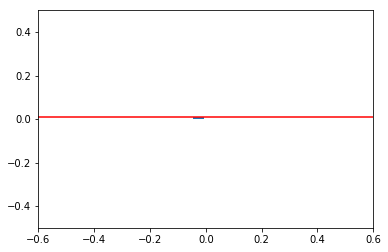

In [14]:
Y_test_pred_reg ={ycol: models["model_l_high_reg"].predict(X_test)}
# print(models["model_l_high_reg"].score(X_test,Y_test[ycol]))
print(models["model_l_high_reg"])

interval = 0.05
n = int(1/interval)
x0 = np.arange(n+1)*interval
y0 = np.ones(x0.shape)* Y_test[ycol].mean()

ycol2 = "y_l"


y1 = []
cnt1 = []
for i in range(-n,n):
    p0 = i*interval
    p1 = (i+1)*interval
    cond=(p0 < Y_test_pred_reg[ycol]) & (Y_test_pred_reg[ycol] <=p1)
    cnt1.append(sum(cond))
    y1.append((Y_test[ycol2][cond].mean(), Y_test[ycol2][cond].median(),
               Y_test[ycol2][cond].std(),Y_test[ycol2][cond].max(),Y_test[
                   ycol2][cond].min()))
for c,p in zip(cnt1,y1):
    print(c,p)

plt.bar(np.arange(-n,n)*interval+interval/2,[mean for mean,_, _,_,_ in y1],
        width=0.8*interval)

x0 = np.arange(-n,n+1)*interval
y0 = np.ones(x0.shape)* Y_test[ycol2].mean()
plt.plot(x0,y0,color='r')
# plt.plot(x,y1,color='r')
plt.xlim(-0.6,0.6)
plt.ylim(-0.5,0.5)
plt.show()

In [27]:
cond = Y_test_pred_reg[ycol]>0.2
print(Y_test[ycol][cond].mean())
print(sum(cond),Y_test[ycol][cond].mean(), Y_test[ycol][cond].median(),Y_test[ycol][cond].std(),Y_test[ycol][cond].max(),Y_test[ycol][cond].min())

df_combined = df_all.loc[test_date_idx][["code","open0","open","f1mv_open"]]
df_combined["rise"] = Y_test["y_l_rise"].copy()
df_combined["pred"] = Y_test_pred_reg[ycol].copy()
for code, df in df_combined[cond].groupby("code"):
    print("\n",df)

0.0815759349200122
52 0.0815759349200122 0.12917428233523276 0.1497680854133822 0.5289189189189187 -0.2129162462159434

                  code  open0        open   f1mv_open      rise      pred
2017-04-27  000002.SZ  20.32  2698.13024  2573.31516  0.074819  0.212407
2017-04-28  000002.SZ  19.38  2573.31516  2562.69260  0.118135  0.219926
2017-05-03  000002.SZ  19.20  2549.41440  2509.57980  0.141799  0.222706
2017-05-04  000002.SZ  18.90  2509.57980  2516.21890  0.138786  0.208485

                  code  open0      open  f1mv_open      rise      pred
2017-05-08  002335.SZ  32.00  95.16800   89.24974  0.205598  0.205736
2017-05-11  002335.SZ  30.03  89.30922   88.98208  0.221341  0.205184

                  code  open0       open  f1mv_open      rise      pred
2017-03-28  002359.SZ  34.99  106.43958  108.69066  0.125105  0.214021
2017-03-29  002359.SZ  35.73  108.69066  102.60666  0.191817  0.210836
2017-04-05  002359.SZ  36.81  111.97602  107.96058  0.132713  0.223536
2017-04-06  0023



                  code  open0       open  f1mv_open      rise      pred
2017-10-09  600779.SH  41.99  264.70496  261.61600  0.204819  0.243296
2017-10-10  600779.SH  41.50  261.61600  261.30080  0.220748  0.201910
2017-11-01  600779.SH  46.25  291.56000  295.53152  0.104949  0.250329
2017-11-02  600779.SH  46.88  295.53152  294.39680  0.109208  0.248233
2017-11-03  600779.SH  46.70  294.39680  302.59200  0.079167  0.248233
2017-11-09  600779.SH  50.44  317.97376  312.36320  0.017154  0.228288
2017-11-17  600779.SH  48.38  304.98752  296.09888  0.043219  0.202894
2017-11-20  600779.SH  46.97  296.09888  293.32512  0.063830  0.257924
2017-11-22  600779.SH  48.00  302.59200  289.98400  0.080435  0.203872
2017-11-29  600779.SH  43.10  271.70240  265.58752  0.183005  0.207145
2017-11-30  600779.SH  42.13  265.58752  262.81376  0.195491  0.228797
2017-12-01  600779.SH  41.69  262.81376  263.69632  0.191489  0.200249
2017-12-12  600779.SH  47.60  300.07040  295.53152  0.063140  0.273760
201